In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# First time point (0% cell lifetime)

In [58]:
# Load Data

x_train = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [59]:
# Load Model

config = {'seed': 42,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encoder60.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decoder60.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


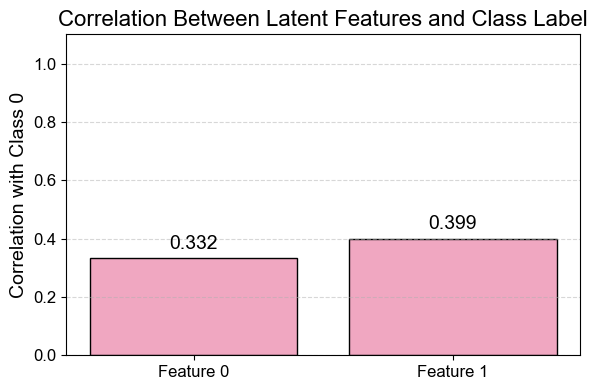

In [60]:
latent_space = encoder.predict(x_train)
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)

# X-axis: Feature indices (0 to 99)
feature_indices = np.arange(len(cor_vals))

plt.figure(figsize=(6, 4))
bars = plt.bar(feature_indices, abs(cor_vals), color="#F0A7C1", edgecolor='black')

# Add value labels on top of each bar (3 decimal places)
for bar, value in zip(bars, abs(cor_vals)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{value:.3f}",
             ha='center', va='bottom', fontsize=14, fontname='Arial')  # Increased fontsize

# Formatting with Arial font
#plt.xlabel("Latent Feature Index", fontsize=14, fontname='Arial')
plt.ylabel("Correlation with Class 0", fontsize=14, fontname='Arial')
plt.title("Correlation Between Latent Features and Class Label", fontsize=16, fontname='Arial')
plt.xticks(ticks=[0, 1], labels=["Feature 0", "Feature 1"], fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ylim(0, 1.1)  # Add a little space for the text above bars

# Optional: Save plot
#plt.savefig("bar_plot_3dim.eps", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


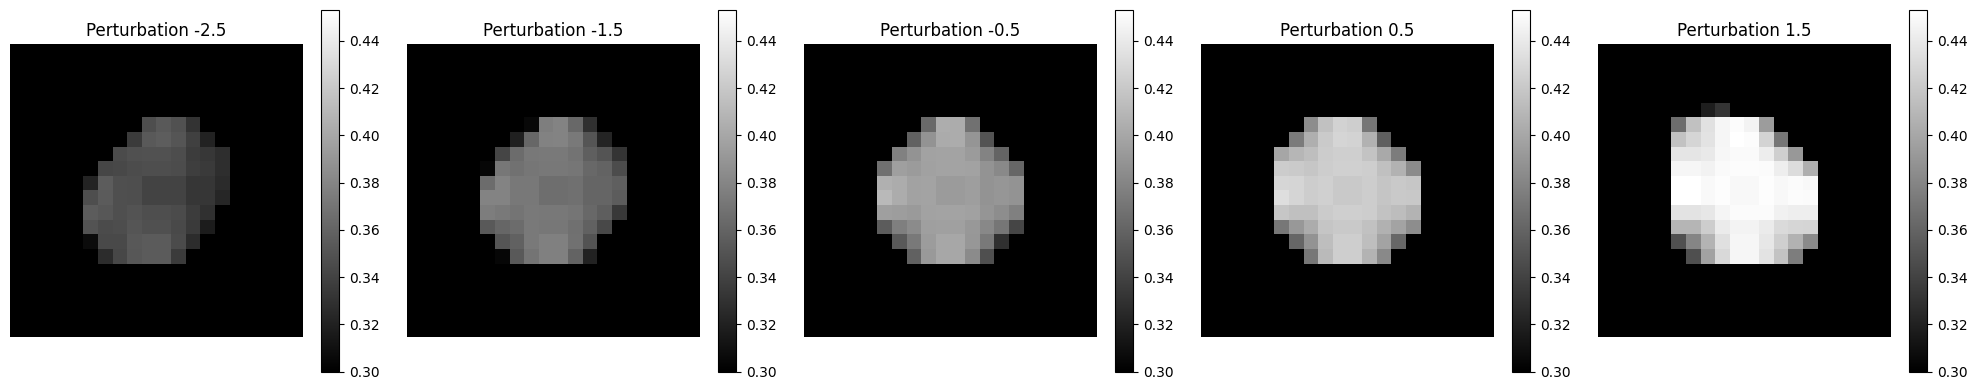

In [62]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
#perturbations = [-3, -2, -1, 0, 1, 2]  
#perturbations = np.linspace(-3, 2, 5) # feature index 1
perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0


# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.3, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


# 50% of cell lifetime 

In [63]:
# Load Data

x_train = np.load('../data/images/time_norm_train_images.npy')[:,5,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,5,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [64]:
# Load Model

config = {'seed': 42,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encodertp5.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decodertp5.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


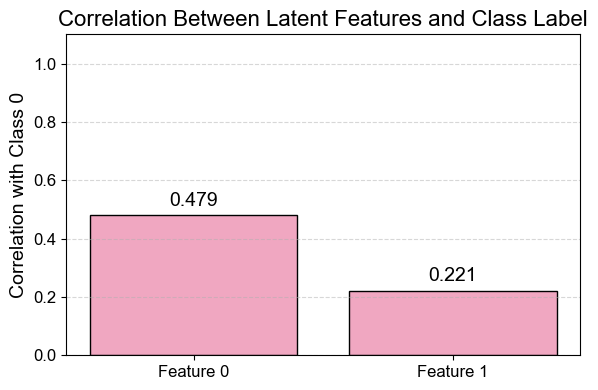

In [65]:
latent_space = encoder.predict(x_train)
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)

# X-axis: Feature indices (0 to 99)
feature_indices = np.arange(len(cor_vals))

plt.figure(figsize=(6, 4))
bars = plt.bar(feature_indices, abs(cor_vals), color="#F0A7C1", edgecolor='black')

# Add value labels on top of each bar (3 decimal places)
for bar, value in zip(bars, abs(cor_vals)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{value:.3f}",
             ha='center', va='bottom', fontsize=14, fontname='Arial')  # Increased fontsize

# Formatting with Arial font
#plt.xlabel("Latent Feature Index", fontsize=14, fontname='Arial')
plt.ylabel("Correlation with Class 0", fontsize=14, fontname='Arial')
plt.title("Correlation Between Latent Features and Class Label", fontsize=16, fontname='Arial')
plt.xticks(ticks=[0, 1], labels=["Feature 0", "Feature 1"], fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ylim(0, 1.1)  # Add a little space for the text above bars

# Optional: Save plot
#plt.savefig("bar_plot_3dim.eps", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


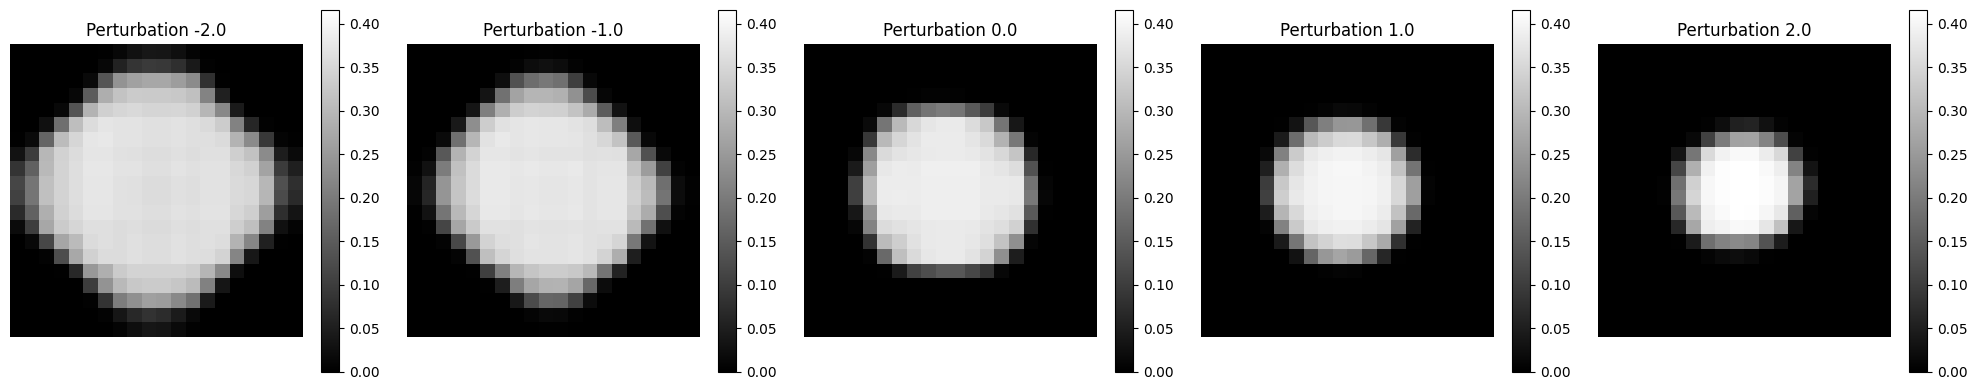

In [68]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 0

# Perturbation range
#perturbations = [-3, -2, -1, 0, 1, 2]  
#perturbations = np.linspace(-3, 2, 5) # feature index 1
perturbations = np.linspace(-2, 2, 5) # feature index 0


# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.0, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


# 100% of cell lifetime

In [69]:
# Load Data

x_train = np.load('../data/images/time_norm_train_images.npy')[:,-1,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,-1,:,:]
y_test = np.load('../data/labels/test_labels.npy')

In [70]:
# Load Model

config = {'seed': 42,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Downloads/encodertp10.weights.h5")
decoder.load_weights("/Users/inescunha/Downloads/decodertp10.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


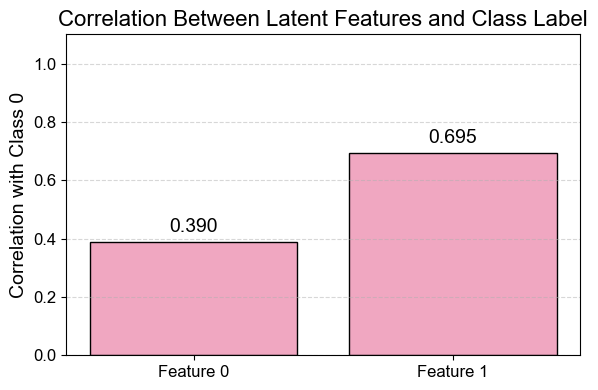

In [71]:
latent_space = encoder.predict(x_train)
cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
cor_vals = np.array(cor_vals)

# X-axis: Feature indices (0 to 99)
feature_indices = np.arange(len(cor_vals))

plt.figure(figsize=(6, 4))
bars = plt.bar(feature_indices, abs(cor_vals), color="#F0A7C1", edgecolor='black')

# Add value labels on top of each bar (3 decimal places)
for bar, value in zip(bars, abs(cor_vals)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{value:.3f}",
             ha='center', va='bottom', fontsize=14, fontname='Arial')  # Increased fontsize

# Formatting with Arial font
#plt.xlabel("Latent Feature Index", fontsize=14, fontname='Arial')
plt.ylabel("Correlation with Class 0", fontsize=14, fontname='Arial')
plt.title("Correlation Between Latent Features and Class Label", fontsize=16, fontname='Arial')
plt.xticks(ticks=[0, 1], labels=["Feature 0", "Feature 1"], fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ylim(0, 1.1)  # Add a little space for the text above bars

# Optional: Save plot
#plt.savefig("bar_plot_3dim.eps", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


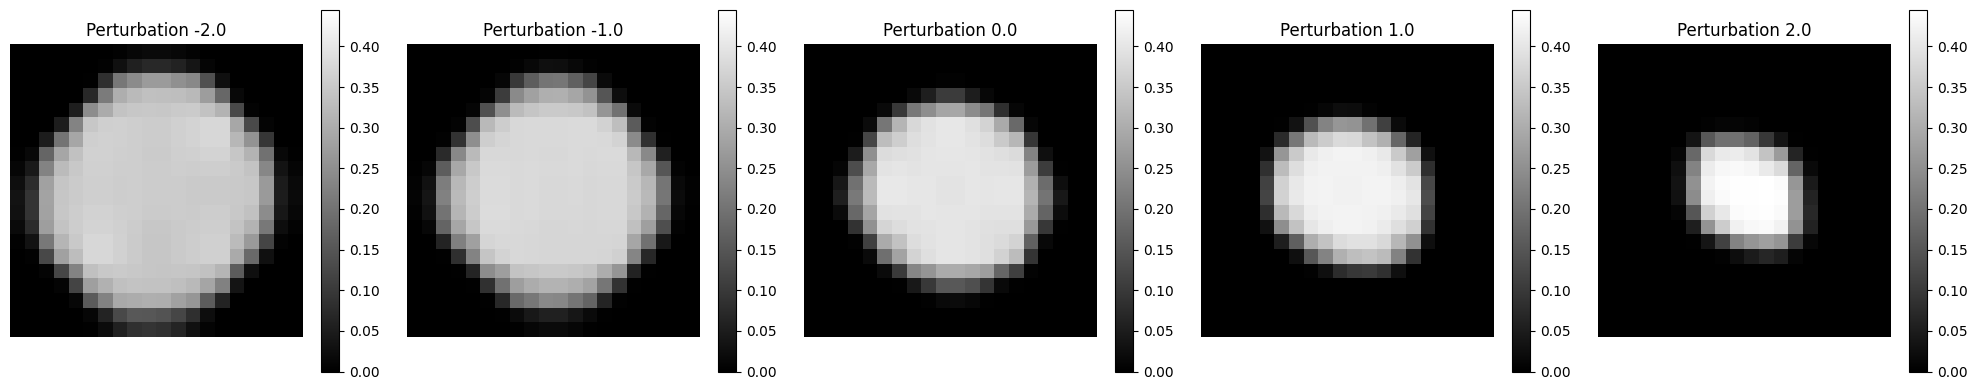

In [76]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = [-3, -2, -1, 0, 1, 2]  
#perturbations = np.linspace(-3, 2, 5) # feature index 1
perturbations = np.linspace(-2, 2, 5) # feature index 0


# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
